In [1]:
import os
import os.path
import sys
d = os.path.join(os.getcwd())
print(d)
sys.path.append(d)

C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src


In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure as Figure
import seaborn as sns
import Other.Colours as CP
import numpy as np
import pandas as pd
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# https://pandas.pydata.org/pandas-docs/stable/visualization.html
# http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html
# https://matplotlib.org/users/pyplot_tutorial.html

# Set up the style of the graphs, and display a sample graph
graph_style = 5
plt.style.use(plt.style.available[graph_style])  # 5, 14, 22
sns.set_context("paper")

Using style 'ggplot'


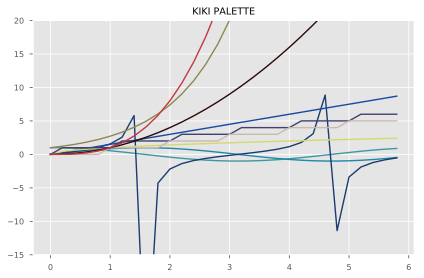

In [3]:
def palette_test(colour):
    t = [t/5.0 for t in range(30)]
    fig = Figure(figsize=(12.0, 15.0), dpi=100) 
    canvas = FigureCanvas(fig)
    direc = '../src/Other/PaletteOutput/'

    functions = [math.cos, math.sin, math.tan, lambda x: 1.5*x, 
                 math.exp, math.sqrt, math.ceil,
                 math.floor, lambda x: x**2, lambda x: x**3]

    for index, fn in enumerate(functions):
        palette = colour+"_"+str(index)
        ax = fig.add_subplot(5, 2, index+1)
        ax.set_title(palette)
        f = [fn(x) for x in t]
        ax.plot(t, f, color=getattr(CP, palette), markersize=5.0) 

    fig.tight_layout()
    fig.savefig(direc + colour + '_PALETTE.svg')
    
    plt.title(colour + ' PALETTE')
    for index, fn in enumerate(functions):
        palette = colour+"_"+str(index)
        f = [fn(x) for x in t]
        plt.plot(t, f, color=getattr(CP, palette))

    plt.ylim(-15, 20)  # limits the y-axis
    plt.tight_layout()
    plt.savefig(direc + colour + '_OVERLAY.svg')

print("Using style '{}'".format(plt.style.available[graph_style]))
palettes = ["KIKI"]
for x in palettes: 
    palette_test(x)

In [4]:
# Changing this variable changes which file to parse.
# Makes testing/presenting easier, since less code has to be changed.
FILENUM = 1

In [11]:
# Standard Imports

# These should not be changed, as they are used to set the 'constant'
# global variables for each module.
from EA_Methods import ParentSelectionMethods as ParentSelectionMethods
from EA_Methods import RecombinationMethods as RecombinationMethods
from EA_Methods import MutationMethods as MutationMethods
from EA_Methods import SurvivorSelectionMethods as SurvivorSelectionMethods
from random import shuffle


# Modular Imports

# Modular Problem Definition
# By changing these imports, you can easily redifine the problem you are attempting
# to solve, without having to re-write much of the code.
from Setups.TSP.TSP import read_tsp_file as parse_file
from Setups.TSP import TSP as TSP

# Modular Function Definitions
# By swapping out which functions are imported, but keeping the aliases,
# the entire structure of the EA algorithm can be changed without rewriting code
# in the main method.
from Setups.TSP.TSP import random_initialization as initialize
from Setups.TSP.TSP import euclidean_distance as eval_fitness
from EA_Methods.ParentSelectionMethods import tournament as parent_selection
from EA_Methods.RecombinationMethods import recombination_cut_crossover as generate_offspring
from EA_Methods.MutationMethods import permutation_swap as apply_mutation
from EA_Methods.SurvivorSelectionMethods import replacement as select_survivors


# Global Variable Initialization
genome_length       =      parse_file(FILENUM)
generation_limit    =      1000
population_size     =      60
mating_pool_size    =      population_size//2 if (population_size//2) % 2 == 0 else (population_size//2)+1  # has to be even

tournament_size     =      population_size//10
crossover_rate      =      0.9
crossover_point     =      genome_length//3
mutation_rate       =      0.2


# Setting key variables in other modules
ParentSelectionMethods.set_tournament_size(tournament_size)
RecombinationMethods.set_crossover_point(crossover_point)
RecombinationMethods.set_crossover_rate(crossover_rate)
MutationMethods.set_mutation_rate(mutation_rate)

TSP.DATAFRAME

,Longitude (Range shifted),Latitude (Range shifted)
0,-3633.33335,-3314.58335
1,-3600.00005,-3247.91665
2,449.99995,-2847.91665
3,-683.33335,-2547.91665
4,-1500.00005,-2547.91665
5,-3033.33335,-2547.91665
6,333.33335,-1964.58335
7,-833.33335,-1564.58335
8,749.99995,-1464.58335
9,-2400.00005,-531.24995


In [6]:
def evolution_algorithm(maximize, print_gens=True, display_freq=None):
    if display_freq is None: display_freq = generation_limit
    
    # Setting dynamic standard for 'best'
    op = max if maximize else min
    ParentSelectionMethods.set_op(op)
    SurvivorSelectionMethods.set_op(op)

    # Initialize Population
    population = initialize(population_size, genome_length)
    fitness = [eval_fitness(i) for i in population]
    
    if print_gens:
        # TODO - Better handle demonstration output.
        print("Locations of the cities:")
        TSP.point_display()

    # Evolution starts
    for generation in range(generation_limit):

        # Generation Info
        if print_gens and (generation % display_freq == display_freq - 1):
            # TODO - Better handle demonstration output.
            op_fit = op(fitness)
            optimal_solutions = [i + 1 for i in range(population_size) if fitness[i] == op_fit]
            #TSP.path_display(optimal_solutions[0])
            print("Generation: {}\n - Best fitness: {}\n - Avg. fitness: {}\n - Number of optimal solutions: {}/{}\n".format(
                generation+1, op(fitness), sum(fitness)/len(fitness), len(optimal_solutions), population_size)
            )

        # Parent Selection
        parents_index = parent_selection(fitness, mating_pool_size)

        # Generate Offspring (Recombination)
        offspring = generate_offspring(population, parents_index)

        # Mutation Application
        offspring = [apply_mutation(i) for i in offspring]
        offspring_fitness = [eval_fitness(i) for i in offspring]

        # Survivor Selection
        population, fitness = select_survivors(population, fitness, offspring, offspring_fitness)
    # Evolution ends
        
    # Final Fitness Info
    op_fit = op(fitness)
    optimal_solutions = [i + 1 for i in range(population_size) if fitness[i] == op_fit]
    print("\nBest solution fitness:", op_fit, "\nNumber of optimal solutions: ", len(optimal_solutions), '/', population_size)
    print("Best solution indexes:\n", optimal_solutions)



Displaying information every 50 generations.


Locations of the cities:
Generation: 50
 - Best fitness: 49745.209272857275
 - Avg. fitness: 52287.42588316702
 - Number of optimal solutions: 8/60

Generation: 100
 - Best fitness: 43923.644345409
 - Avg. fitness: 45423.65275922146
 - Number of optimal solutions: 1/60

Generation: 150
 - Best fitness: 40047.08775324275
 - Avg. fitness: 41166.34021712972
 - Number of optimal solutions: 23/60

Generation: 200
 - Best fitness: 38405.24626216008
 - Avg. fitness: 39261.49875822795
 - Number of optimal solutions: 42/60

Generation: 250
 - Best fitness: 38110.6653930821
 - Avg. fitness: 38835.98324886306
 - Number of optimal solutions: 54/60

Generation: 300
 - Best fitness: 37145.91645416751
 - Avg. fitness: 37283.02790654956
 - Number of optimal solutions: 1/60

Generation: 350
 - Best fitness: 37145.91645416751
 - Avg. fitness: 38197.41738522295
 - Number of optimal solutions: 54/60

Generation: 400
 - Best fitness: 36929.28042808156
 - Avg

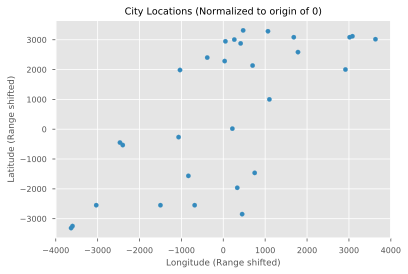

In [7]:
freq = min(int(generation_limit * 0.1), 50)
print('\n\nDisplaying information every {} generations.\n\n'.format(freq))
evolution_algorithm(False, True, freq)

## Helper Functions

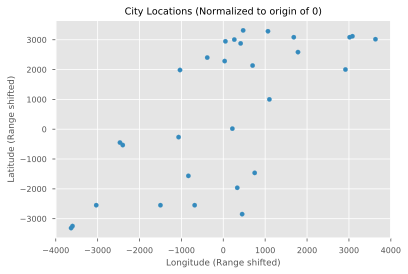

In [8]:
# Sahara
parse_file(1)
TSP.point_display()
#TSP.brute_force_solver()

Warning! Takes approximately 1.5 seconds per decade


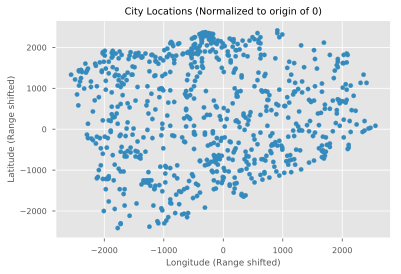

In [9]:
# Uraguay
parse_file(2)
TSP.point_display()
#TSP.brute_force_solver()

Warning! Takes approximately 45 seconds per decade


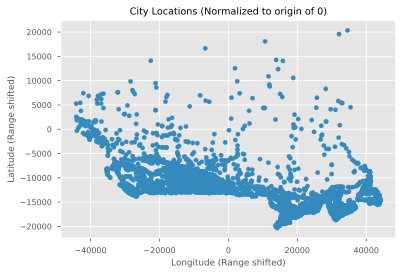

In [10]:
# Canada
parse_file(3)
TSP.point_display()
#TSP.brute_force_solver()